### They inner atoms, and the outer atoms are equally spaced

In [2]:
from tqdm import tqdm
from qutip import *
import numpy as np

from scipy.optimize import minimize

import os

import matplotlib.pyplot as plt
import matplotlib.animation as animation
from functools import partial

In [3]:
save_path = r'C:\Users\leopo\OneDrive - UT Cloud\Uni\Semester_8\BA_mit_Git\BA_Plots\Qutip'
os.makedirs(os.path.dirname(save_path), exist_ok=True)

In [4]:
fixed_lam = 1
fixed_gamma = 1

fixed_dist_ext = 0.235  * fixed_lam
fixed_dist_in  =  fixed_dist_ext
fixed_phi  = 0
########################################                 Define constants                   #############################################
N = 3 + 3 * 1

dist_0   = fixed_dist_ext / 2
dist_max = 1.9 * fixed_dist_ext

t_max    = 40

phi_0    = 0
phi_max  = 2 * np.pi / 3

dist_size = 200
t_size    = 200

########################################################################################################################    
dists  = np.linspace(dist_0, dist_max, dist_size)
times  = np.linspace(0, t_max, t_size) * fixed_gamma

In [10]:
########################################               define the geometry                 #############################################
def dipole_vector(phi = fixed_phi):
    """Returns the dipole vector given its orientation by angle phi."""
    dipole = np.array([np.cos(phi), np.sin(phi), 0])
    return dipole
#d_hats_1 = np.array([np.array([1, 0, 0]) for _ in range(N // 3 - 1)])
#d_hats_rest = np.array([np.array([1, 1, 0] / np.sqrt(2)) for _ in range(N - (N // 3- 2))])
d_hats = np.array([np.array([0, 0, 1]) for _ in range(N)])# np.concatenate((d_hats_1, d_hats_rest), axis=0)  #
#d_hats_test = np.array([dipole_vector(fixed_phi) for _ in range(N)])

def z_rotation(angle):
    return np.array([
        [np.cos(angle), -np.sin(angle), 0],
        [np.sin(angle), np.cos(angle), 0],
        [0, 0, 1]
    ])
def chain_positions(distance, N):
    Pos = np.zeros((N, 3))
    for i in range(N):
        Pos[i, 0] = i * distance
    return Pos

# Function to create positions for a topology with three chains meeting at the origin
def topo_positions(distance_in = fixed_dist_in, distance_ext = fixed_dist_ext, N = N):
    Pos = np.zeros((N, 3))
#    Chain = chain_positions(distance_ext, N // 3)
#    theta = np.arcsin(1/2)
#    Pos[:N//3] = np.dot(Chain, z_rotation(np.pi).T)
#    Pos = Pos[Pos[:, 0].argsort()]
#    Pos[N//3:2*N//3] = np.dot(Chain, z_rotation(+theta).T) + [distance_in * np.cos(theta), +distance_in * np.sin(theta), 0]
#    Pos[2*N//3:] = np.dot(Chain, z_rotation(-theta).T)     + [distance_in * np.cos(theta), -distance_in * np.sin(theta), 0]
# HERE IT HAS A DIFFERENT ANGLE! (ORIGIN in middle of triangle) # TODO
    r = distance_in / np.sqrt(3)
    Chain = chain_positions(distance_ext, N // 3) + [r, 0, 0]
    Pos[:N//3] = np.dot(Chain, z_rotation(np.pi).T)
    Pos = Pos[Pos[:, 0].argsort()]
    Pos[N//3:2*N//3] = np.dot(Chain, z_rotation(2 * np.pi / 6).T)
    Pos[2*N//3:] = np.dot(Chain, z_rotation(-2 * np.pi / 6).T)
    
    return Pos
# Function to create positions for a topology with three chains meeting at the origin
def topo_positions_only_1_inner(distance_in = fixed_dist_in, distance_ext = fixed_dist_ext, N = N):
    if distance_in >= 2 * distance_ext:
        raise ValueError("The distance distance_in is too large to form a valid triangle with distance_ext.")
    Pos = np.zeros((N, 3))
    Chain = chain_positions(distance_ext, N // 3)
    theta = np.arcsin(distance_in / (2 * distance_ext))
    Pos[:N//3] = np.dot(Chain, z_rotation(np.pi).T)
    Pos = Pos[Pos[:, 0].argsort()]
    Pos[N//3:2*N//3] = np.dot(Chain, z_rotation(+theta).T) + [distance_ext * np.cos(theta), +distance_ext * np.sin(theta), 0]
    Pos[2*N//3:] = np.dot(Chain, z_rotation(-theta).T)     + [distance_ext * np.cos(theta), -distance_ext * np.sin(theta), 0]
    
    return Pos

positions = topo_positions(0.8 * fixed_dist_in, fixed_dist_in)

In [11]:
########################################             create the Hamiltonean                 #################################################
def Green_tensor(r_a, r_b, k_a):
    r_ab = r_b - r_a
    abs_r_ab = np.linalg.norm(r_ab)
    kappa = k_a * abs_r_ab
    return (np.exp(1j * kappa) / (4 * np.pi * kappa ** 2 * abs_r_ab)
                    * ((kappa ** 2 + 1j * kappa - 1) * np.eye(3)
                       + (- kappa ** 2 - 3 * 1j * kappa + 3)
                       * np.outer(r_ab, r_ab) / (abs_r_ab ** 2)))

def Gamma_matrix(distance_in, distance_ext, dipoles, lam, gamma):
    positions = topo_positions(distance_in, distance_ext)
    G_matrix = np.zeros((N, N), dtype=complex)
    for a in range(N):
        for b in range(N):
            G_matrix[a, b] = gamma
            r_a, r_b = positions[a], positions[b]
            if np.linalg.norm(r_b - r_a) > 1e-5:
                d_a, d_b = dipoles[a], dipoles[b]
                k_a = 2 * np.pi / lam
                G_matrix[a, b] = np.imag((6 * np.pi * gamma / k_a * np.matmul(np.conj(d_a), np.matmul(Green_tensor(r_a, r_b, k_a), d_b.T))))
    return G_matrix

def V_matrix(distance_in, distance_ext, dipoles, lam, gamma):
    positions = topo_positions(distance_in, distance_ext)
    V_matrix = np.zeros((N, N), dtype=complex)
    for a in range(N):
        for b in range(N):
            r_a, r_b = positions[a], positions[b]
            V_matrix[a, b] = 0
            if np.linalg.norm(r_b - r_a) > 1e-5:
                d_a, d_b = dipoles[a], dipoles[b]
                k_a = 2 * np.pi / lam
                V_matrix[a, b] = np.real((3 * np.pi * gamma / k_a * np.matmul(np.conj(d_a), np.matmul(Green_tensor(r_a, r_b, k_a), d_b.T))))
    return V_matrix
    
def H_eff(distance_in = fixed_dist_in, distance_ext = fixed_dist_ext, dipoles = [dipole_vector() for _ in range(N)], lam=fixed_lam, gamma=fixed_gamma):
    G = Gamma_matrix(distance_in, distance_ext, dipoles, lam, gamma)
    V = V_matrix(distance_in, distance_ext, dipoles, lam, gamma)
    return Qobj(V) - 1j / 2 * Qobj(G)
# ###############
# For Optimization and plotting
# ###############

def survival_probabilities(dipoles, times, distance_in = fixed_dist_in, distance_ext = fixed_dist_ext, gamma=fixed_gamma, Psi_0=basis(N, N//6)):
    H = H_eff(distance_in = distance_in, distance_ext = distance_ext, dipoles=dipoles, lam=fixed_lam, gamma=gamma, N=N)
    coeffs_sq_mods  = np.zeros((len(times), N))
    P_surs  = np.zeros((len(times)))
    for t_idx, t in enumerate(times):
        U = (-1j * H * t).expm()
        Psi_t = (U * Psi_0).full().flatten()
        Probs = np.abs(Psi_t)**2

        coeffs_sq_mods[t_idx, :] = Probs
        P_surs[t_idx] = Probs.sum()

    return coeffs_sq_mods, P_surs

def compute_total_phase(dist_in, d_hats):
    H = H_eff(distance_in=dist_in, distance_ext=fixed_dist_ext, dipoles=d_hats, lam=fixed_lam, gamma=fixed_gamma, N=N)
    phase = (np.angle(H[N//3 - 1, N//3]) +
             np.angle(H[N//3, N - N//3]) +
             np.angle(H[N - N//3, N//3 - 1])) / (2 * np.pi)
    return phase

def total_phases(distances, dipoles, N=N):
    total_ps = np.zeros((len(distances)))
    for i, distance in enumerate(tqdm(distances, desc='Iteration')):
        total_ps[i] = compute_total_phase(distance, dipoles)
    return total_ps

def update(frame, d_hats):
    distance_in = dists[frame]
    phase_value = compute_total_phase(distance_in, d_hats)

    y1, y2 = survival_probabilities(d_hats, times, distance_in=distance_in, Psi_0=psi0)
    
    cax1.set_data(y1.T)
    cax1.set_extent([0, t_max, 0, N-1])
    axs[0, 0].set_title(f'Time evolution of atom state probabilities, distance_in={distance_in:.2f}, ' + r'$P_{tot} = $ ' + f'{phase_value:.2f}')
    
    positions = topo_positions(distance_in=distance_in, distance_ext=fixed_dist_ext, N=N)
    scat.set_offsets(positions[:, :2])
    axs[0, 1].set_title(f'Atom Positions, distance_in={distance_in:.2f}')
    
    # Clear previous arrows
    [arrow.remove() for arrow in axs[0, 1].patches]
    
    # Draw arrows for dipoles
    for i in range(N):
        axs[0, 1].arrow(positions[i, 0], positions[i, 1], d_hats[i][0] * 0.1, d_hats[i][1] * 0.1, head_width=0.5 * 0.1, head_length=0.5 * 0.1, fc='red', ec='red')
    
    line1.set_data(times, y2)
    line2.set_data(times, np.exp(-times))
    axs[1, 0].relim()
    axs[1, 0].autoscale_view()
    
    line3.set_data(dists, phases)
    marker.set_data(dists[frame], phases[frame])
    axs[1, 1].relim()
    axs[1, 1].autoscale_view()
    
    return cax1, scat, line1, line2, line3, marker

def objective(params, times, distance_ext, gamma, Psi_0, target_indices):
    angles = params[:-1]
    distance_in = params[-1]
    dipoles = np.array([dipole_vector(phi) for phi in angles])
    H = H_eff(distance_in=distance_in, distance_ext=distance_ext, dipoles=dipoles, lam=fixed_lam, gamma=gamma, N=N)
    U = (-1j * H * times[-1]).expm()
    Psi_t = (U * Psi_0).full().flatten()
    Probs = np.abs(Psi_t)**2
    rest = np.ones(len(Probs), dtype=bool)
    # Sum probabilities of the states in the right arms
#    rest[target_indices] = False
    target_prob = np.sum(Probs[target_indices])#) # - np.sum(Probs[rest]
    # We want to maximize the target probability
    return -target_prob

[[ 0.17407766+0.j          0.17407766+0.j          0.17407766+0.j
  ...  0.17407766+0.j          0.17407766+0.j
   0.17407766+0.j        ]
 [ 0.17407766+0.j          0.11999968+0.12610752j -0.00863513+0.17386335j
  ...  0.11794054-0.12803538j  0.1740548 -0.00282067j
   0.12202731+0.12414655j]
 [ 0.17407766+0.j         -0.00863513+0.17386335j -0.17322096-0.017249j
  ... -0.01426425-0.17349225j  0.17398625-0.0056406j
  -0.00299694+0.17405186j]
 ...
 [ 0.17407766+0.j          0.11794054-0.12803538j -0.01426425-0.17349225j
  ...  0.16409576+0.05810001j  0.15391062-0.08132989j
   0.04445831-0.16830475j]
 [ 0.17407766+0.j          0.1740548 -0.00282067j  0.17398625-0.0056406j
  ...  0.15391062-0.08132989j  0.15257258-0.08381311j
   0.15119449-0.08627432j]
 [ 0.17407766+0.j          0.12202731+0.12414655j -0.00299694+0.17405186j
  ...  0.04445831-0.16830475j  0.15119449-0.08627432j
   0.16751441+0.04734928j]]


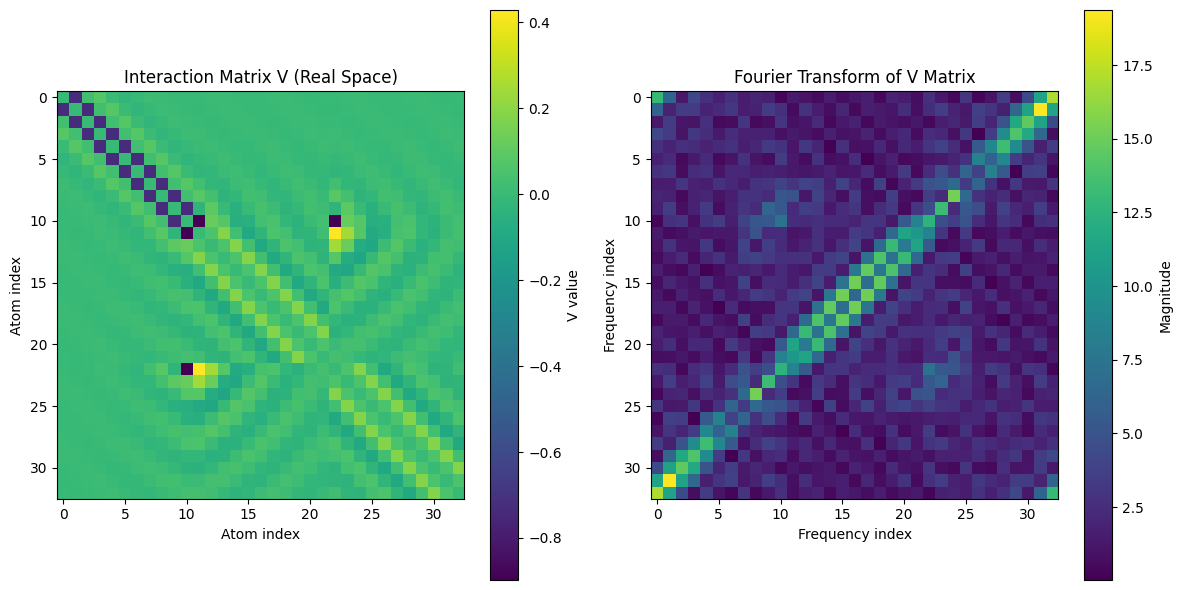

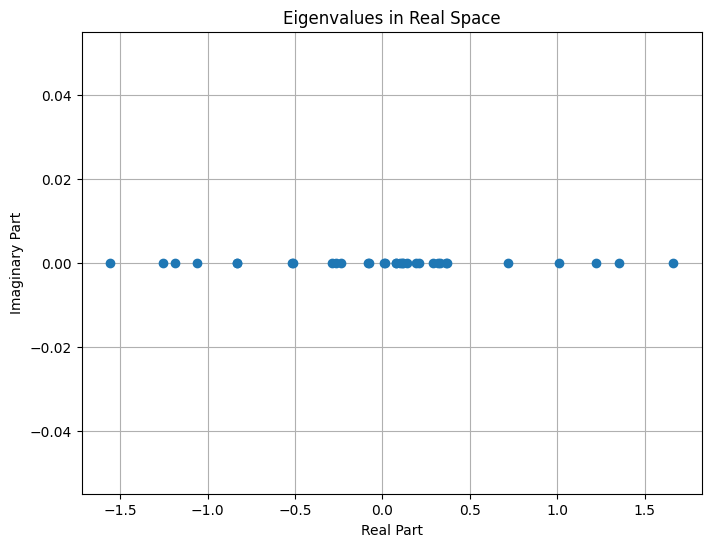

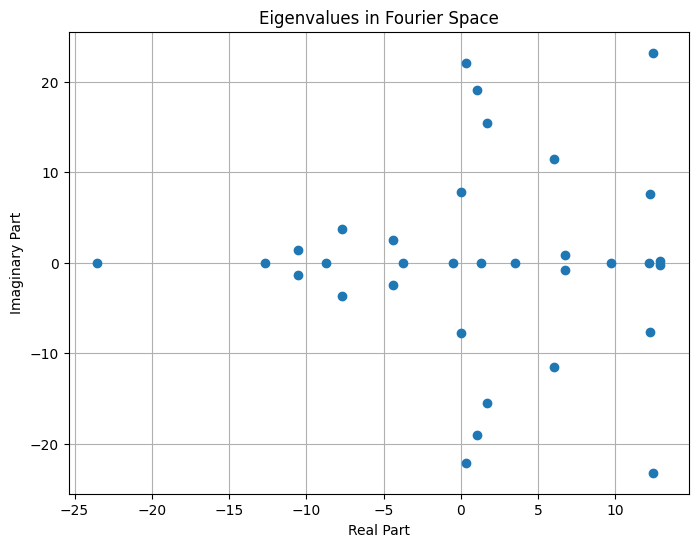

In [10]:
def Trafo(kd_range) -> np.ndarray:
    T_temp = np.zeros((N,N), dtype=complex)
    for i in range(kd_range.size):
        T_temp[:, i] = np.exp(1j * np.arange(0, N) * kd_range[i])

    return 1 / np.sqrt(N) * T_temp

kd_range = np.arange(0, N) * 2 * np.pi / (N * fixed_dist_ext)

print(Trafo(kd_range))
V_matrix = np.zeros((N, N))

for i in range(N):
    for j in range(N):
        V_matrix[i, j] = V_coefficients(positions[i], positions[j])

# Perform the Fourier transform
from scipy.fft import fft2, fftshift
V_fourier = fftshift(fft2(V_matrix))

from numpy.linalg import eig
# Compute the eigenvalues of the real-space matrix
eigenvalues_real, _ = eig(V_matrix)

# Perform the Fourier transform
V_fourier = fftshift(fft2(V_matrix))

# Compute the eigenvalues of the Fourier-transformed matrix
eigenvalues_fourier, _ = eig(V_fourier)

# Plot the results
plt.figure(figsize=(12, 6))

# Plot the real-space matrix V
plt.subplot(1, 2, 1)
plt.title('Interaction Matrix V (Real Space)')
plt.imshow(V_matrix, cmap='viridis', interpolation='nearest')
plt.colorbar(label='V value')
plt.xlabel('Atom index')
plt.ylabel('Atom index')

# Plot the Fourier-space matrix V
plt.subplot(1, 2, 2)
plt.title('Fourier Transform of V Matrix')
plt.imshow(np.abs(V_fourier), cmap='viridis', interpolation='nearest')
plt.colorbar(label='Magnitude')
plt.xlabel('Frequency index')
plt.ylabel('Frequency index')

plt.tight_layout()
plt.show()

# Plot the eigenvalues in real space
plt.figure(figsize=(8, 6))
plt.title('Eigenvalues in Real Space')
plt.plot(np.real(eigenvalues_real), np.imag(eigenvalues_real), 'o')
plt.xlabel('Real Part')
plt.ylabel('Imaginary Part')
plt.grid(True)
plt.show()

# Plot the eigenvalues in Fourier space
plt.figure(figsize=(8, 6))
plt.title('Eigenvalues in Fourier Space')
plt.plot(np.real(eigenvalues_fourier), np.imag(eigenvalues_fourier), 'o')
plt.xlabel('Real Part')
plt.ylabel('Imaginary Part')
plt.grid(True)
plt.show()

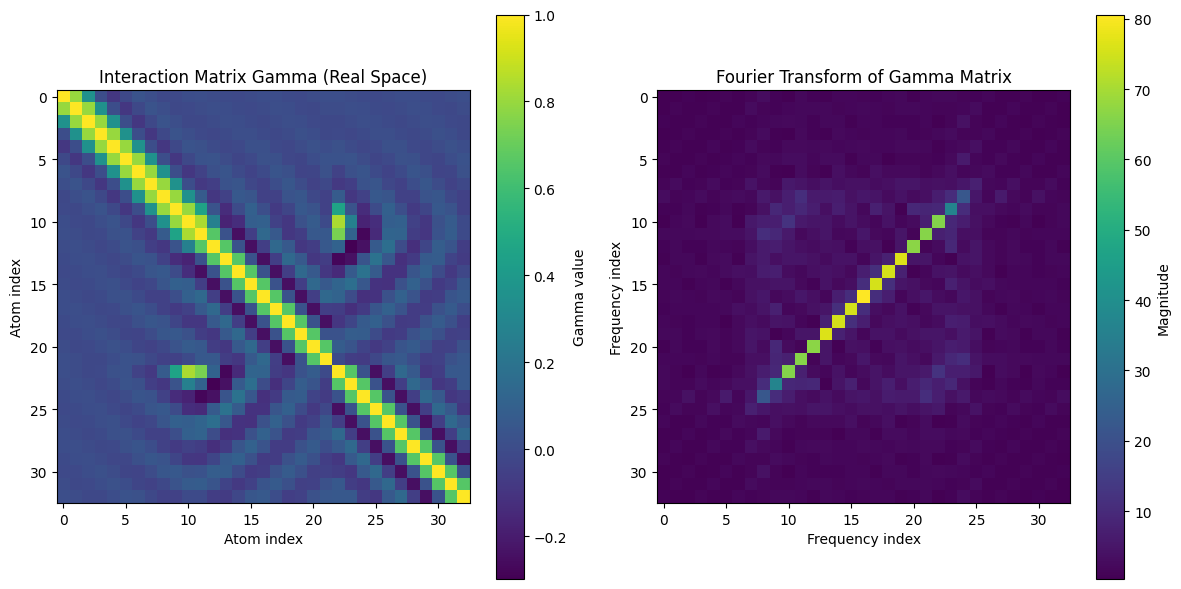

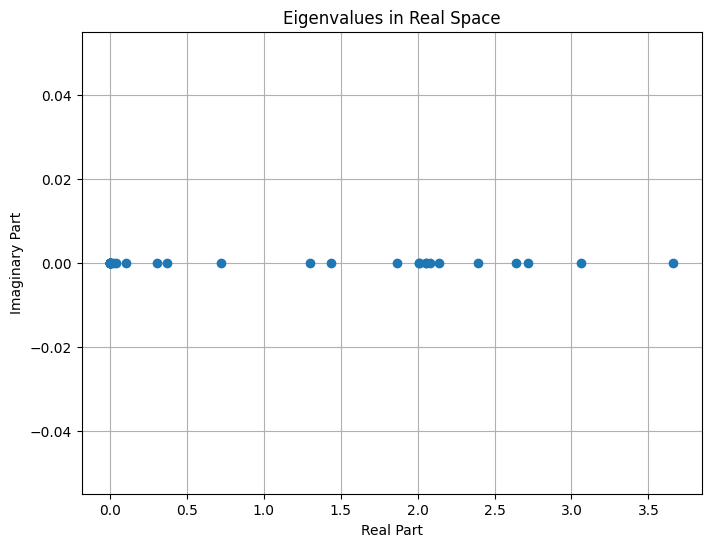

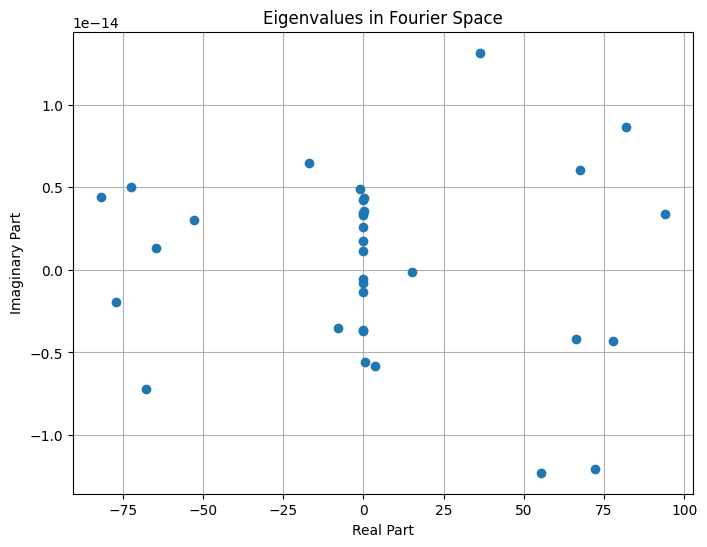

In [11]:
Gamma_matrix = np.zeros((N, N))

for i in range(N):
    for j in range(N):
        Gamma_matrix[i, j] = Gamma_coefficients(positions[i], positions[j])

# Perform the Fourier transform
Gamma_fourier = fftshift(fft2(Gamma_matrix))
# Compute the eigenvalues of the real-space matrix
Gamma_eigenvalues_real, _ = eig(Gamma_matrix)
# Compute the eigenvalues of the Fourier-transformed matrix
Gamma_eigenvalues_fourier, _ = eig(Gamma_fourier)

# Plot the results
plt.figure(figsize=(12, 6))

# Plot the real-space matrix Gamma
plt.subplot(1, 2, 1)
plt.title('Interaction Matrix Gamma (Real Space)')
plt.imshow(Gamma_matrix, cmap='viridis', interpolation='nearest')
plt.colorbar(label='Gamma value')
plt.xlabel('Atom index')
plt.ylabel('Atom index')

# Plot the Fourier-space matrix Gamma
plt.subplot(1, 2, 2)
plt.title('Fourier Transform of Gamma Matrix')
plt.imshow(np.abs(Gamma_fourier), cmap='viridis', interpolation='nearest')
plt.colorbar(label='Magnitude')
plt.xlabel('Frequency index')
plt.ylabel('Frequency index')

plt.tight_layout()
plt.show()

# Plot the eigenvalues in real space
plt.figure(figsize=(8, 6))
plt.title('Eigenvalues in Real Space')
plt.plot(np.real(Gamma_eigenvalues_real), np.imag(Gamma_eigenvalues_real), 'o')
plt.xlabel('Real Part')
plt.ylabel('Imaginary Part')
plt.grid(True)
plt.show()

# Plot the eigenvalues in Fourier space
plt.figure(figsize=(8, 6))
plt.title('Eigenvalues in Fourier Space')
plt.plot(np.real(Gamma_eigenvalues_fourier), np.imag(Gamma_eigenvalues_fourier), 'o')
plt.xlabel('Real Part')
plt.ylabel('Imaginary Part')
plt.grid(True)
plt.show()

# Investigate Photon storage

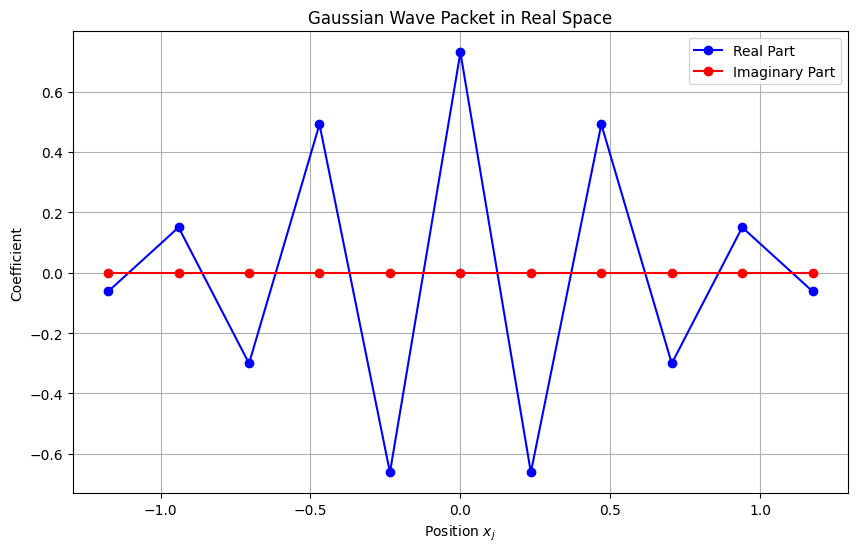

Quantum object: dims=[[33], [1]], shape=(33, 1), type='ket', dtype=Dense
Qobj data =
[[-0.0424681 ]
 [ 0.10323599]
 [-0.20600282]
 [ 0.33743405]
 [-0.45370999]
 [ 0.50077367]
 [-0.45370999]
 [ 0.33743405]
 [-0.20600282]
 [ 0.10323599]
 [-0.0424681 ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]]

In [12]:
################ initiate Wave-packet
k_s = np.pi / fixed_dist_ext
sigma = 0.1 * k_s
kd_range = np.arange(0, N) * 2 * np.pi / (N * fixed_dist_ext)
center_index = N // 6
x_j = (np.arange(N//3) - center_index) * fixed_dist_ext

# Calculate the Gaussian wave packet in real space
coefficients = np.sqrt(sigma / np.sqrt(2 * np.pi)) * np.exp(-1j * k_s * x_j) * np.exp(-sigma**2 * x_j**2)
wave_packet = sum(coeff * basis(N, j) for j, coeff in enumerate(coefficients))
psi0 = wave_packet.unit()

# Plot the real and imaginary parts of the wave packet coefficients
plt.figure(figsize=(10, 6))
plt.plot(x_j, coefficients.real, 'bo-', label='Real Part')
plt.plot(x_j, coefficients.imag, 'ro-', label='Imaginary Part')
plt.xlabel('Position $x_j$')
plt.ylabel('Coefficient')
plt.title('Gaussian Wave Packet in Real Space')
plt.legend()
plt.grid(True)
plt.show()
#psi0 = basis(N,0)
psi0

Optimal parameters for upper arm loaded


Iteration: 100%|██████████| 200/200 [00:29<00:00,  6.85it/s]


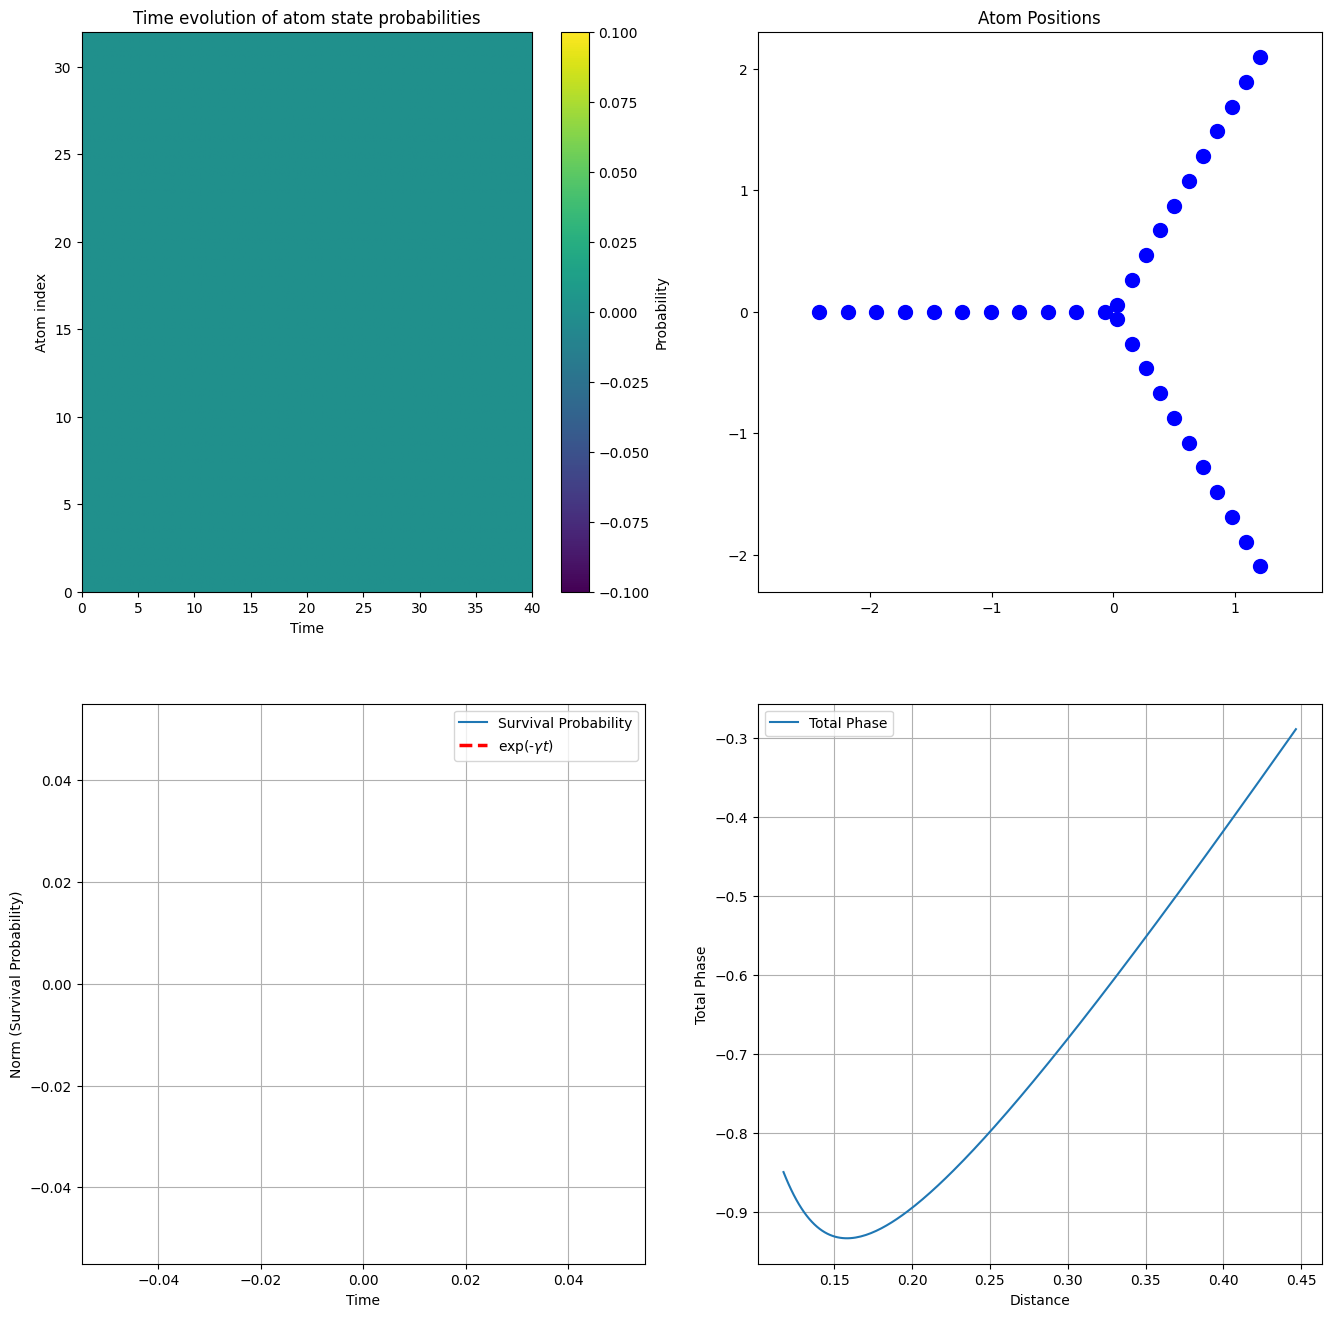

In [15]:
#
# Animate the distance dependence for a fixed dipole configurations
#
# Set up the figure and axes
if os.path.isfile(save_path + r'\optimal_params_upper.npy'):
    # Load the optimal agnles
    optimal_params = np.load(save_path + r'\optimal_params_upper.npy')
    optimal_angles = optimal_params[:-1]
    optimal_dist_in = optimal_params[-1]
    optimal_dipoles = [dipole_vector(phi) for phi in optimal_angles]
    print(f"Optimal parameters for upper arm loaded")
fig, axs = plt.subplots(2, 2, figsize=(16, 16))

# Initialize plots
cax1 = axs[0, 0].imshow(np.zeros((N, len(times))), aspect='auto', origin='lower', cmap='viridis', extent=[0, t_max, 0, N-1])
fig.colorbar(cax1, ax=axs[0, 0], label='Probability')
axs[0, 0].set_xlabel('Time')
axs[0, 0].set_ylabel('Atom index')
axs[0, 0].set_title('Time evolution of atom state probabilities')

positions = topo_positions(distance_in=dists[0], distance_ext=fixed_dist_ext, N=N)
scat = axs[0, 1].scatter(positions[:, 0], positions[:, 1], color='blue', s=100)
axs[0, 1].set_title('Atom Positions')
axs[0, 1].axis('equal')

line1, = axs[1, 0].plot([], [], label='Survival Probability')
line2, = axs[1, 0].plot([], [], 'r--', linewidth=2.5, label=r'exp(-$\gamma t$)')
axs[1, 0].set_xlabel('Time')
axs[1, 0].set_ylabel('Norm (Survival Probability)')
axs[1, 0].legend()
axs[1, 0].grid(True)

phases = total_phases(dists, optimal_dipoles)
line3, = axs[1, 1].plot(dists, phases, label='Total Phase')
marker, = axs[1, 1].plot([], [], 'ro')  # Red marker for current phase and position
axs[1, 1].set_xlabel('Distance')
axs[1, 1].set_ylabel('Total Phase')
axs[1, 1].legend()
axs[1, 1].grid(True)

In [16]:
# Check if the optimal parameters file exists
# Create the animation with the optimized dipoles
ani_opt = animation.FuncAnimation(fig, partial(update, d_hats=optimal_dipoles), frames=len(dists), blit=True, repeat=False, interval=100)
ani_opt.save(save_path + r'\Optimized_upper_arm.gif', writer='pillow', dpi=200)
plt.tight_layout()
plt.show()

# Example: d_hats_test and d_hats_test1 are different sets of dipoles
#ani_test = animation.FuncAnimation(fig, partial(update, d_hats=d_hats_test), frames=len(dists), blit=True, repeat=False, interval=50)
#ani_test.save(save_path + r'\Test___.gif', writer='pillow')
#plt.tight_layout()
#plt.show()

KeyboardInterrupt: 

In [ ]:
# #################
# Optimize the transition amp into one of the right arms, for the distance and the dipole orientation
# #################
# Define initial parameters (example)
initial_angles = np.zeros(N)
initial_dist_in = fixed_dist_in

# Combine angles and distance_in into a single array for optimization
initial_params = np.hstack((initial_angles, initial_dist_in))
# Define the bounds for the angles (0 to 2*pi) and for distance_in
angle_bounds = [(0, 2*np.pi) for _ in range(N)]
distance_in_bounds = [(0, None)]  # Adjust this bound according to your physical constraints
bounds = angle_bounds + distance_in_bounds

# Indices of the atoms in the right arms
target_indices = list(range(N//3, 2*N//3))  # Example, assuming the right arms are the latter half

# Optimization with bounds
result = minimize(objective, initial_params, args=(times, fixed_dist_ext, fixed_gamma, psi0, target_indices), method='SLSQP', bounds=bounds)
optimal_params = result.x
optimal_angles = optimal_params[:-1]
optimal_dist_in = optimal_params[-1]

optimal_dipoles = np.array([dipole_vector(phi) for phi in optimal_angles])

print("Optimal Angles:", optimal_angles)
print("Optimal Dipoles:", optimal_dipoles)
print("Optimal Distance In:", optimal_dist_in)
# Save the optimal parameters
#np.save(save_path + r'\optimal_params.npy', optimal_params)

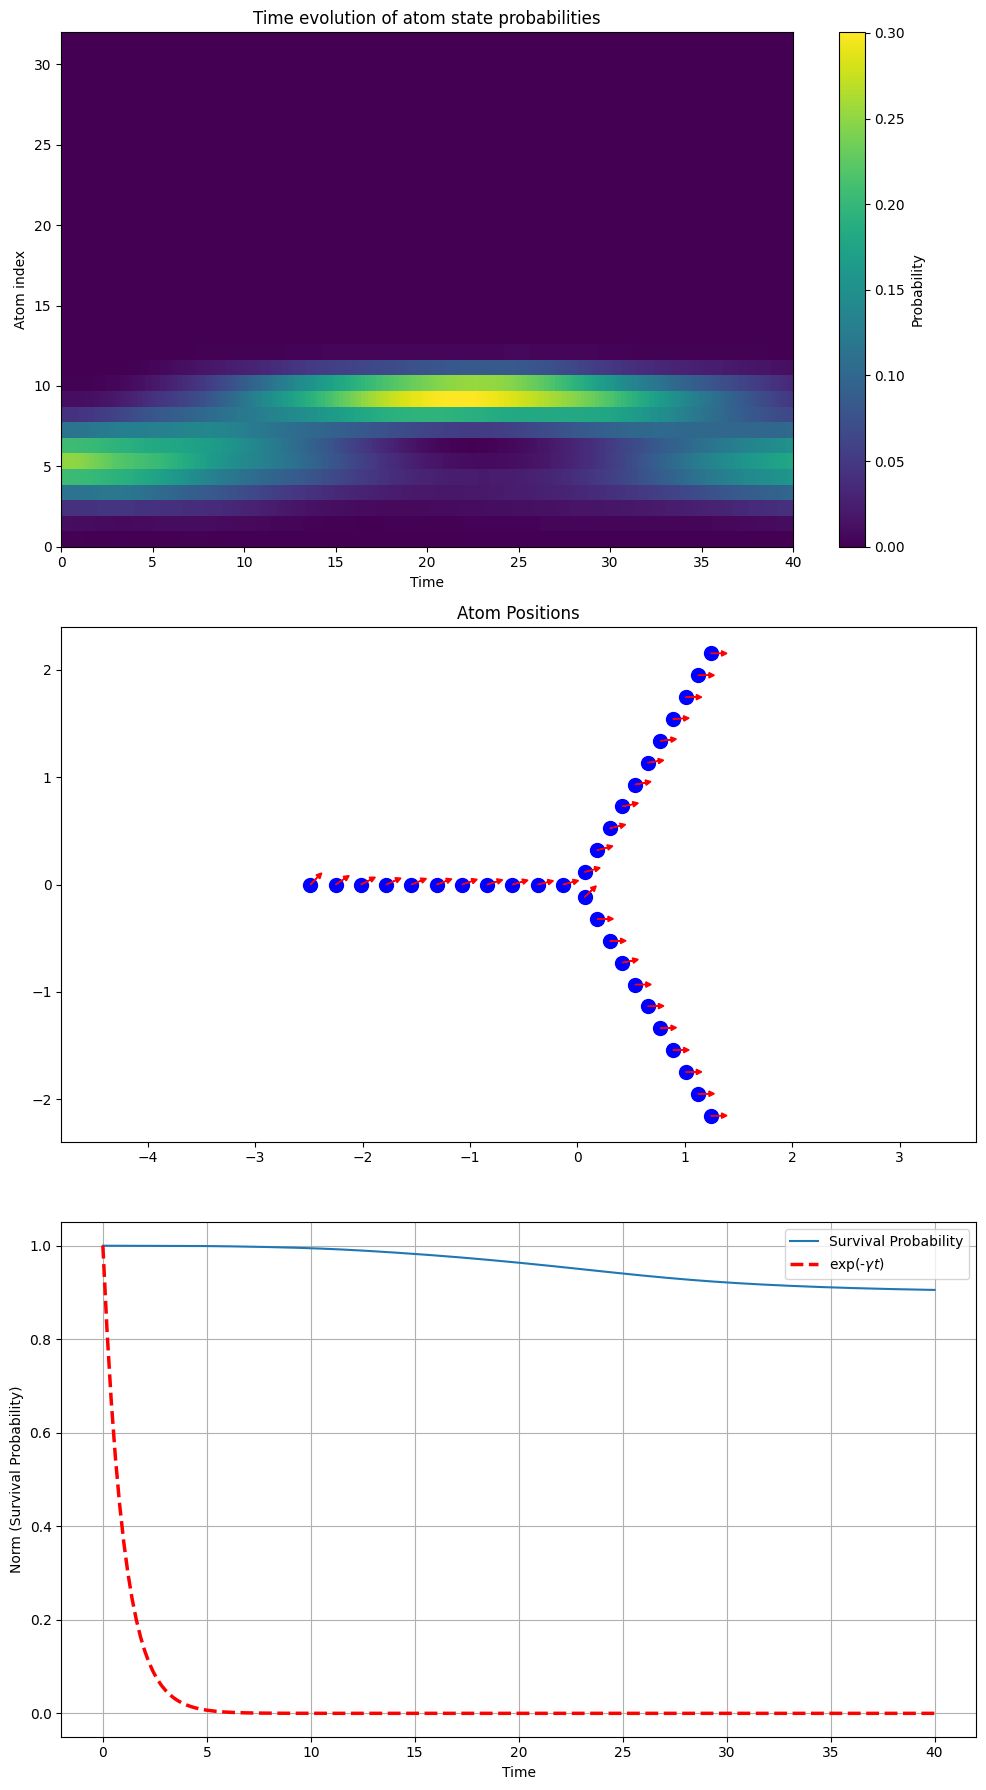

In [17]:
# #################
# Plot the optimization for fixed distance and the dipole orientation 
# #################
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(10, 18))

# Time evolution plot
times = np.linspace(0, t_max, t_size)
coeffs_sq_mods, P_surs = survival_probabilities(optimal_dipoles, times, distance_in=optimal_dist_in, Psi_0=psi0)

cax1 = ax1.imshow(coeffs_sq_mods.T, aspect='auto', origin='lower', cmap='viridis', extent=[0, t_max, 0, N-1])
fig.colorbar(cax1, ax=ax1, label='Probability')
ax1.set_xlabel('Time')
ax1.set_ylabel('Atom index')
ax1.set_title('Time evolution of atom state probabilities')

# Atom positions plot
positions = topo_positions(distance_in=optimal_dist_in, distance_ext=fixed_dist_ext, N=N)
scat = ax2.scatter(positions[:, 0], positions[:, 1], color='blue', s=100)
ax2.set_title('Atom Positions')
ax2.axis('equal')

# Draw arrows for dipoles
for i in range(N):
    ax2.arrow(positions[i, 0], positions[i, 1], optimal_dipoles[i][0] * 0.1, optimal_dipoles[i][1] * 0.1, head_width=0.5 * 0.1, head_length=0.5 * 0.1, fc='red', ec='red')

# Survival probability plot
line1, = ax3.plot(times, P_surs, label='Survival Probability')
line2, = ax3.plot(times, np.exp(-times), 'r--', linewidth=2.5, label=r'exp(-$\gamma t$)')
ax3.set_xlabel('Time')
ax3.set_ylabel('Norm (Survival Probability)')
ax3.legend()
ax3.grid(True)

plt.tight_layout()
#plt.savefig(save_path + r'\OptimalPlot_upper_with_correct_topo.png')
plt.show()

# Investigate Phasses

In [ ]:
#
# Only the inner distance is varied
#
def total_phases(distances, dipoles, N = N):
    total_ps = np.zeros((len(distances)))
    for i, distance in enumerate(tqdm(distances, desc='Iteration')):
        dist_in = distance
        dist_ext = fixed_dist_ext
        H = H_eff(distance_in = dist_in, distance_ext = dist_ext, dipoles=dipoles, lam=fixed_lam, gamma=fixed_gamma, N=N)
        p = (np.angle(H[N//3 - 1 , N//3]) +
             np.angle(H[N//3, N - N//3]) +
             np.angle(H[N - N//3, N//3 - 1])) / (2 * np.pi)
        total_ps[i] = p
    return total_ps
phases = total_phases(dists, optimal_dipoles)

In [ ]:
# plot phi(distances for a dipole orientation)
fig, ax = plt.subplots()
plt.plot(dists, phases, label=r'total Phase/ $\pi$')
plt.xlabel(r'distance x')
plt.ylabel(r'Phase / $2\pi$')
plt.title(f'Phase of off-diagonal entries of H over distance for $\phi$')#={fixed_phi:.2f}
#plt.legend()
plt.show()

# old implementation

In [ ]:
'''
# Define an optimization function that returns the negative of survival probability
def optimization_target(dist):
    _, res = survival_probabilities(d_hats, [times[t_size//2]], distance_ext=dist[0])
    return -res[0]

def positive_distance_constraint(distance):
    return distance - 0.1 * fixed_lam
initial_distance = 0.234 * fixed_lam  # Initial guess for the distance
constraints = [{'type': 'ineq', 'fun': positive_distance_constraint}]
print(initial_distance)
result = minimize(optimization_target, initial_distance, method='SLSQP', constraints=constraints, options={'maxiter': 1000})

optimized_distance = result.x[0]
print(optimized_distance)
y1, y2 = survival_probabilities(d_hats, times, distance_in=optimized_distance, Psi_0=psi0)
plt.figure(figsize=(10, 6))
plt.imshow(y1.T, aspect='auto', origin='lower', cmap='viridis', extent=[0, t_max, 0, N-1])
plt.colorbar(label='Probability')
plt.xlabel('Time')
plt.ylabel('Atom index')
plt.title('Time evolution of atom state probabilities')
plt.show()
# Plot atoms with their dipole moments
positions = topo_positions(distance_in=optimized_distance, distance_ext=fixed_dist_ext, N=N)
max_x = np.max(positions[:, 0])
scale = 0.1 * max_x
plt.figure(figsize=(8, 8))
plt.scatter(positions[:, 0], positions[:, 1], color='blue', s=100, label='Atoms')
for i in range(N):
    plt.arrow(positions[i, 0], positions[i, 1], d_hats[i][0] * 0.1, d_hats[i][1] * 0.1, head_width=0.5 * 0.1, head_length=0.5 * 0.1, fc='red', ec='red')
plt.title('Atom Positions and optimal Dipole Moments')
plt.xlabel('X Position')
plt.ylabel('Y Position')
plt.grid(True)
plt.legend()
plt.axis('equal')
plt.show()

# Plot the norms against time
plt.figure(figsize=(10, 6))
plt.plot(times, y2, label='Survival Probability')
plt.plot(times, np.exp(-times), 'r--', linewidth=2.5, label=r'exp(-$\gamma t$)')
plt.xlabel('Time')
plt.ylabel('Norm (Survival Probability)')
plt.title('Survival Probability vs. Time')
plt.legend()
plt.grid(True)
plt.show()
'''

In [ ]:
########################################               define the geometry                 #############################################
def dipole_vector(phi = fixed_phi):
    """Returns the dipole vector given its orientation by angle phi."""
    dipole = np.array([np.cos(phi), np.sin(phi), 0])
    return dipole
d_hats_1 = np.array([np.array([1, 0, 0]) for _ in range(N // 3)])
d_hats_rest = np.array([np.array([0, 0, 1]) for _ in range(N - (N // 3))])
# Combine both arrays
d_hats = np.concatenate((d_hats_1, d_hats_rest), axis=0)

def topo_positions(distance_in = fixed_dist_in, distance_ext = fixed_dist_ext, N = N):
    """ Returns     np.ndarray: Positions of the six atoms as a Nx3 array. """
    Pos = np.zeros((N, 3))

    # Calculate the inner triangle vertices (atoms 2, 3, 4)
    cos = np.cos(2 * np.pi / 6) # 60 degrees in radians
    sin = np.sin(2 * np.pi / 6) # 60 degrees in radians
    x = distance_in / (2 * np.cos(np.pi / 6)) # 30 deg
    Pos[0] = (- x, 0, 0)
    Pos[1] = (+ x * cos, + x * sin, 0)
    Pos[2] = (+ x * cos, - x * sin, 0)

    for i in range((N-1) // 3):
        Pos[3 * (i+1)] = Pos[0]     + (- (i+1) * distance_ext, 0, 0)
        Pos[3 * (i+1) + 1] = Pos[1] + (+ (i+1) * distance_ext * cos, + (i+1) * distance_ext * sin, 0)
        Pos[3 * (i+1) + 2] = Pos[2] + (+ (i+1) * distance_ext * cos, - (i+1) * distance_ext * sin, 0)
        
    Pos_sorted = Pos[Pos[:, 0].argsort()]

    return Pos_sorted

positions = topo_positions(fixed_dist_in, fixed_dist_in)
print(positions)
d_hat = d_hats[0]
max_x = np.max(positions[:, 0])
scale = 0.1 * max_x
# Plot the atom positions
plt.figure(figsize=(8, 6))
plt.plot(positions[:, 0], positions[:, 1], 'o', markersize=10, label='atoms')
plt.arrow(0, 0, d_hat[0] * scale, d_hat[1] * scale, 
          head_width=0.5*scale, head_length=0.5*scale, fc='r', ec='r', label='dipole vec')
# Plot dipole vectors
#for i, position in enumerate(positions):
#    plt.arrow(position[0], position[1], d_hat[0] * scale, d_hat[1] * scale, 
#              head_width=0.2*scale, head_length=0.2*scale, fc='r', ec='r')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.axis('equal')
plt.show()

In [ ]:
#
#
# TRY TO OPTIMISE PHI
#
## calculate the optimal phi configuration
from scipy.optimize import differential_evolution

def H_eff(distance_in = fixed_dist_in, distance_ext = fixed_dist_ext, dipoles = [dipole_vector() for _ in range(N)], lam=fixed_lam, gamma=fixed_gamma, N=N):
    positions = topo_positions(distance_in, distance_ext, N)
    H_eff_matrix = np.zeros((N, N), dtype=complex)
    for a in range(N):
        for b in range(N):
            r_a = positions[a]
            r_b = positions[b]
            V_ab = V_coefficients(r_a, r_b, dipoles[a], dipoles[b], lam, gamma)
            Gamma_ab = Gamma_coefficients(r_a, r_b, dipoles[a], dipoles[b], lam, gamma)
            matrix_element = V_ab - 1j * 0.5 * Gamma_ab
            H_eff_matrix[a, b] = matrix_element
    return Qobj(H_eff_matrix)

def norms_cal(times, distance_in = fixed_dist_in, distance_ext = fixed_dist_ext, gamma=fixed_gamma, dipoles=[dipole_vector() for _ in range(N)], Psi_0=basis(N, 0)):
    H = H_eff(distance_in = distance_in, distance_ext = distance_ext, dipoles=dipoles, lam=fixed_lam, gamma=gamma, N=N)
    all_norms = []
    for t in times:
        U = (-1j * H * t).expm()
        Psi_t = U * Psi_0
        norm_sq = Psi_t.norm()**2
        print(norm_sq)
        all_norms.append(norm_sq)
    return np.array(all_norms)

# Define the cost function to be minimized (negative of the survival probability at t=10*gamma)
def cost_function(phis):
    dipoles = [dipole_vector(phi) for phi in phis]
    survival_probabilities = norms_cal([times[t_size//2]], dipoles=dipoles, Psi_0=psi0)
    survival_probability = survival_probabilities[0]
    return -survival_probability

# Define the bounds for each phi value
bounds = [(0, 2 * np.pi) for _ in range(N)]

############################################################################################ uncomment here
# Define the custom initial population 
def custom_initial_population(N):
    init_pop = np.zeros(N)
    init_pop[N//3:] = np.tile([np.pi/3, -np.pi/3], (N - N//3) // 2)
    return init_pop

# Create the initial population with differential_evolution initialization
def differential_evolution_with_custom_init():
    popsize = 15
    mutation = (0.5, 1)
    recombination = 0.7
    maxiter = 1000
    tol = 0.01

    strategy = 'best1bin'
    init = 'latinhypercube'
    seed = None

    initial_pop = np.array([custom_initial_population(N) for _ in range(popsize)])

    def custom_callback(xk, convergence):
        pass  # Define any custom callback logic here if needed

    result = differential_evolution(
        cost_function,
        bounds,
        strategy=strategy,
        maxiter=maxiter,
        popsize=popsize,
        tol=tol,
        mutation=mutation,
        recombination=recombination,
        seed=seed,
        callback=custom_callback,
        disp=True,
        polish=True,
        init=initial_pop
    )
    return result
result = differential_evolution_with_custom_init() # Perform the optimization
############################################################################################ uncomment here ''' ''' 
#result = differential_evolution(cost_function, bounds)
optimal_phis = result.x
optimal_survival_probability = -result.fun

print(f"Optimal phis: {optimal_phis}")
print(f"Optimal survival probability: {optimal_survival_probability}")

optimal_dipoles = np.array([dipole_vector(phi) for phi in optimal_phis]).flatten()

# Calculate norms over the entire time range
P_sur = []
for time in times:
    norm = survival_probability(optimal_dipoles, [time], psi0)
    P_sur.append(norm)
    
print(P_sur)
# Plot the norms against time
plt.figure(figsize=(10, 6))
plt.plot(times, P_sur, label='Survival Probability')
plt.plot(times, np.exp(-times), 'r--', linewidth=2.5, label=r'exp(-$\gamma t$)')
plt.xlabel('Time')
plt.ylabel('Norm (Survival Probability)')
plt.title('Survival Probability vs. Time for Optimal $\phi$ Configuration')
plt.legend()
plt.grid(True)
plt.show()

# Plot atoms with their dipole moments
positions = topo_positions(fixed_dist_in, fixed_dist_ext, N)
max_x = np.max(positions[:, 0])
scale = 0.1 * max_x
optimal_dipoles = optimal_dipoles.reshape((N, 3))
plt.figure(figsize=(8, 8))
plt.scatter(positions[:, 0], positions[:, 1], color='blue', s=100, label='Atoms')
for i in range(N):
    plt.arrow(positions[i, 0], positions[i, 1], optimal_dipoles[i][0] * scale, optimal_dipoles[i][1] * scale, head_width=0.5 * scale, head_length=0.5 * scale, fc='red', ec='red')

plt.title('Atom Positions and Dipole Moments')
plt.xlabel('X Position')
plt.ylabel('Y Position')
plt.grid(True)
plt.legend()
plt.axis('equal')
plt.show()

In [ ]:
# FAST MOEDRN
def survival_probability(dipoles, times, Psi_0, distance_in=fixed_dist_in, distance_ext=fixed_dist_ext, lam=fixed_lam, gamma=fixed_gamma, N=N):
    dipoles = dipoles.reshape((N, 3))
    H = H_eff(distance_in, distance_ext, dipoles, lam, gamma, N)
    U = (-1j * H * times[len(times) // 2]).expm()
    Psi_t = U * Psi_0
    norm_sq = (Psi_t.norm())**2
    return norm_sq

# Define an optimization function that returns the negative of survival probability
def optimization_target(dipoles_flat):
    dipoles = dipoles_flat.reshape((N, 3))
    return -survival_probability(dipoles, times, psi0)

# Initial guess for the dipole orientations (flattened array)
initial_dipoles = np.array([dipole_vector() for _ in range(N)]).flatten()

from scipy.optimize import minimize
# Constraint to ensure each dipole vector remains a unit vector
def unit_vector_constraint(dipoles_flat):
    dipoles = dipoles_flat.reshape((N, 3))
    return np.array([np.linalg.norm(dipole) - 1 for dipole in dipoles])

# Define the constraints
constraints = [{'type': 'eq', 'fun': unit_vector_constraint}]

# Optimize
result = minimize(optimization_target, initial_dipoles, method='SLSQP', constraints=constraints, options={'maxiter': 1000})

# Extract the optimal dipoles
optimal_dipoles_flat = result.x
optimal_dipoles = optimal_dipoles_flat.reshape((N, 3))

print("Optimal Dipoles:", optimal_dipoles)

print(result)
# Plot atoms with their dipole moments
positions = topo_positions(fixed_dist_in, fixed_dist_ext, N)
max_x = np.max(positions[:, 0])
scale = 0.1 * max_x
plt.figure(figsize=(8, 8))
plt.scatter(positions[:, 0], positions[:, 1], color='blue', s=100, label='Atoms')
for i in range(N):
    plt.arrow(positions[i, 0], positions[i, 1], optimized_dipoles[i][0] * 0.1, optimized_dipoles[i][1] * 0.1, head_width=0.5 * 0.1, head_length=0.5 * 0.1, fc='red', ec='red')
plt.title('Atom Positions and optimal Dipole Moments')
plt.xlabel('X Position')
plt.ylabel('Y Position')
plt.grid(True)
plt.legend()
plt.axis('equal')
plt.show()

norms = []
for time in times:
    norm = survival_probabilities(optimized_dipoles.flatten(), [time], Psi_0=psi0)
    norms.append(norm)
#print(norms)
# Plot the norms against time
plt.figure(figsize=(10, 6))
plt.plot(times, norms, label='Survival Probability')
plt.plot(times, np.exp(-times), 'r--', linewidth=2.5, label=r'exp(-$\gamma t$)')
plt.xlabel('Time')
plt.ylabel('Norm (Survival Probability)')
plt.title('Survival Probability vs. Time for Optimal $\phi$ Configuration')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
#
# PROBLEM::::::::::: DIPOLES WERDEN ZU GROßßß !!!!!!!
#
# Define the survival probability function
def survival_probabilities(times, distance_in = fixed_dist_in, distance_ext = fixed_dist_ext, gamma=fixed_gamma, dipoles=[dipole_vector() for _ in range(N)], Psi_0=basis(N, 0)):
    H = H_eff(distance_in = distance_in, distance_ext = distance_ext, dipoles=dipoles, lam=fixed_lam, gamma=gamma, N=N)
    print(H)
    coeffs_sq_mods  = np.zeros((len(times), N))
    P_surs  = np.zeros((len(times)))
    for t_idx, t in enumerate(times):
        U = (-1j * H * t).expm()
        Psi_t = (U * Psi_0).full().flatten()
        Probs = np.abs(Psi_t)**2

        coeffs_sq_mods[t_idx, :] = Probs
        P_surs[t_idx] = Probs.sum()

    return coeffs_sq_mods, P_surs
# Define an optimization function that returns the negative of survival probability
def optimization_target(dipoles_flat):
    dipoles = dipoles_flat.reshape((N, 3))
    _, res = survival_probabilities([times[-1]], dipoles=dipoles)
    return -res[-1]

# Initial guess for the dipole orientations (flattened array)
initial_dipoles = np.array([dipole_vector() for _ in range(N)]).flatten()

# Perform the optimization
result = minimize(optimization_target, initial_dipoles, method='L-BFGS-B')

# Reshape the optimized dipoles to their original shape
optimized_dipoles = result.x.reshape((N, 3))

# Print the optimized dipoles
print("Optimized dipoles:")
print(optimized_dipoles)

for i, dipole in enumerate(optimized_dipoles):
    norm = np.linalg.norm(dipole)
    optimized_dipoles[i] = (dipole / norm)

y1, y2 = survival_probabilities(times, dipoles=optimized_dipoles, Psi_0=psi0)
print(y1, y2)

# Calculate survival probability
# Create a heatmap for state probabilities
plt.figure(figsize=(10, 6))
plt.imshow(y1, aspect='auto', origin='lower', cmap='viridis', extent=[0, t_max, 0, N-1])
plt.colorbar(label='Probability')
plt.xlabel('Time')
plt.ylabel('Atom index')
plt.title('Time evolution of atom state probabilities')
plt.show()

# Plot survival probability
plt.figure(figsize=(10, 6))
plt.plot(times, y2, 'r-', label='Survival Probability')
plt.plot(times, np.exp(-times), 'r--', linewidth=2.5, label=r'exp(-$\gamma t$)')
plt.xlabel('Time')
plt.ylabel('Survival Probability')
plt.title('Survival Probability over time')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# Plot atoms with their dipole moments
positions = topo_positions(fixed_dist_in, fixed_dist_ext, N)
max_x = np.max(positions[:, 0])
scale = 0.1 * max_x

plt.figure(figsize=(8, 8))
plt.scatter(positions[:, 0], positions[:, 1], color='blue', s=100, label='Atoms')
for i in range(N):
    plt.arrow(positions[i, 0], positions[i, 1], optimized_dipoles[i][0] * scale, optimized_dipoles[i][1] * scale, head_width=0.5 * scale, head_length=0.5 * scale, fc='red', ec='red')

plt.title('Atom Positions and Dipole Moments')
plt.xlabel('X Position')
plt.ylabel('Y Position')
plt.grid(True)
plt.legend()
plt.axis('equal')
plt.show()

In [ ]:
########################################             create the Hamiltonean                 ################################################# old version
#jetzt direkter weg zur NxN matrix
def H_eff(N: int,
          distance_in: float = fixed_dist_in, 
          distance_ext: float = fixed_dist_ext, 
          phi: float = fixed_phi,
          gamma: float = fixed_gamma):

    d_hat = dipole_vector(phi)
    H_eff_matrix = np.zeros((N, N), dtype=complex)
    pos = topo_positions(distance_in, distance_ext, N)

    for i in range(N):
        for j in range(N):
            V_ij = 0
            if i == j:
                Gamma_ij = gamma
            else:
                r_ij = pos[j] - pos[i]
                x = np.linalg.norm(r_ij)
                r_hat_ij = r_ij / x
                k = 2 * np.pi * x
                dot_ij = np.dot(d_hat, r_hat_ij)

                Gamma_ij = 3/2 * gamma * ((1 - (dot_ij)**2) * np.sin(k) / k +
                                          (1 - 3 * (dot_ij)**2) * (np.cos(k)/k**2 -
                                                                   np.sin(k) / k**3))

                V_ij = - 3/4 * gamma * ((1 - (dot_ij)**2) * np.cos(k) / k -
                                        (1 - 3 * (dot_ij)**2) * (np.sin(k)/k**2 +
                                                                 np.cos(k) / k**3))

            matrix_element = V_ij - 1j * 0.5 * Gamma_ij
            H_eff_matrix[i, j] = matrix_element
            
#            self._Gamma = matrix_element.imag  ???????
    return Qobj(H_eff_matrix)
H_ex = H_eff(N)
H_ex

In [ ]:
'''def ladder_operator(i, operator_type, N = N):
    if i <= 0 or i > N:
        raise ValueError("Index i out of range. Use 1 <= i <= N")
    if operator_type not in ['lowering', 'raising']:
        raise ValueError("Invalid operator type. Use 'lowering' or 'raising'.")
    if operator_type == 'lowering':
        op_atom = destroy(2)  # Outer product |g⟩⟨e| = ((0,1), (0,0))
    else:
        op_atom = create(2)  # Outer product |e⟩⟨g| = ((0,0), (1,0))
    identity_list = [qeye(2) for _ in range(N)]
    identity_list[i - 1] = op_atom
    op = tensor(identity_list)
    return op

def single_excitation_basis(N = N):
    basis_states = []
    for i in range(N):
        state_list = [basis(2, 0)] * N
        state_list[i] = basis(2, 1)
        basis_state = tensor(state_list)
        basis_states.append(basis_state)
    return basis_states

def generic_superposition(basis_states, coefficients=None):
    N = len(basis_states)
    if coefficients is None:
        coefficients = np.random.rand(N) + 1j * np.random.rand(N)
        coefficients /= np.linalg.norm(coefficients)
    
    superposition = sum(c * state for c, state in zip(coefficients, basis_states))
    return superposition.unit()

def H_eff(distance_in: float = fixed_dist_in,
          distance_ext: float = fixed_dist_ext,
          phi: float = fixed_phi,
          gamma: float = fixed_gamma,
          N: int = N):

    d_hat = dipole_vector(phi)
    pos = topo_positions(distance_in, distance_ext)
    H_V = 0
    H_Gamma = 0
    for i in range(N):
        for j in range(N):
            V_ij = 0
            if i == j:
                Gamma_ij = gamma
            else:
                r_ij = pos[j] - pos[i]
                x = np.linalg.norm(r_ij)
                r_hat_ij = r_ij / x
                k = 2 * np.pi * x
                dot_ij = np.dot(d_hat, r_hat_ij)

                Gamma_ij = 3/2 * gamma * ((1 - (dot_ij)**2) * np.sin(k) / k +
                                          (1 - 3 * (dot_ij)**2) * (np.cos(k)/k**2 -
                                                                   np.sin(k) / k**3))

                V_ij = - 3/4 * gamma * ((1 - (dot_ij)**2) * np.cos(k) / k -
                                        (1 - 3 * (dot_ij)**2) * (np.sin(k)/k**2 +
                                                                 np.cos(k) / k**3))
                
            raising_op_i  = ladder_operator(i+1, 'raising')
            lowering_op_j = ladder_operator(j+1, 'lowering')
                
            H_Gamma += Gamma_ij * (raising_op_i * lowering_op_j)
            H_V     += V_ij     * (raising_op_i * lowering_op_j)

    return H_V - 1/2 * 1j * H_Gamma

def H_eff_red(distance_in: float = fixed_dist_in,
              distance_ext: float = fixed_dist_ext,
              phi: float = fixed_phi,
              gamma: float = fixed_gamma,
              N: int = N):
    
    H = H_eff(distance_in, distance_ext, phi, gamma, N)
    single_exc_basis = single_excitation_basis(N)
    H_reduced = np.zeros((N, N), dtype=complex)

    for i, bra in enumerate(single_exc_basis):
        for j, ket in enumerate(single_exc_basis):
            H_reduced[i, j] = H.matrix_element(bra.dag(), ket)

    return Qobj(H_reduced)
# example form of the Hamiltonean
H_red_ex = H_eff_red()
H_red_ex'''